## Skip unless in Google Colab

In [1]:
!pip install transformers
!pip install datasets
!pip install sentencepiece
!pip install pytorch_lightning
!pip install rouge_score

     |████████████████████████████████| 2.3MB 5.1MB/s 
     |████████████████████████████████| 901kB 37.0MB/s 
     |████████████████████████████████| 3.3MB 32.8MB/s 
     |████████████████████████████████| 225kB 5.0MB/s 
     |████████████████████████████████| 245kB 18.1MB/s 
     |████████████████████████████████| 112kB 17.3MB/s 
     |████████████████████████████████| 1.2MB 4.9MB/s 
     |████████████████████████████████| 808kB 5.1MB/s 
     |████████████████████████████████| 276kB 10.9MB/s 
     |████████████████████████████████| 645kB 16.8MB/s 
     |████████████████████████████████| 829kB 21.9MB/s 
     |████████████████████████████████| 1.3MB 26.7MB/s 
     |████████████████████████████████| 296kB 30.4MB/s 
     |████████████████████████████████| 143kB 44.2MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=abca944ea3be035b85760d2f52ec8feb6558d9c9d688948f3d57a9690279c0b9
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd3

## Configure Google Drive mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/t5-fine-tuning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/t5-fine-tuning


## Start from here if running locally

###### if running locally, need to install ipywidgets: conda install -c conda-forge ipywidgets / pip install ipywidgets==7.6.3

In [1]:
import argparse
import glob
import os
from pathlib import Path
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from datasets import load_dataset, load_metric


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /home/axelallen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
try:
    FILE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    print('__file__ does not exist for notebook, use current directory instead')
    FILE_DIR = Path().resolve()
    
print(f'current directory is: {FILE_DIR}')

__file__ does not exist for notebook, use current directory instead
current directory is: /home/axelallen/Documents/LGT/team_saga/nlg


## Configure the dataset

In [3]:
dataset = load_dataset('cnn_dailymail', '2.0.0')
dataset

Dataset cnn_dailymail downloaded and prepared to /home/axelallen/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [10]:
print(dataset['train'][0].keys())

dict_keys(['article', 'highlights', 'id'])


In [11]:
print(f"ARTICLE: {dataset['train'][0]['article']}\n")
print(f"HIGHLIGHTS: {dataset['train'][0]['highlights']}\n")
print(f"ID: {dataset['train'][0]['id']}")


ARTICLE: It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It's a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but because h

In [14]:
text_len = []
summary_len=[]
phase = ['train', 'validation', 'test']
long_summaries = []
long_articles = []
short_articles = []
short_summaries = []

for p in phase:
  for i in range(len(dataset[p])):
      example = dataset[p][i]
      article = example['article'].replace('\n','').split(" ")
      text_len.append(len(article))

      summary = example['highlights'].replace('\n','').split(" ")
      summary_len.append(len(summary))

      if len(article) < 150:
        short_articles.append(example)
      if len(article) > 512:
        long_articles.append(example)
      if len(summary) > 150:
        long_summaries.append(example)
      if len(summary) < 24:
        short_summaries.append(example)

In [15]:
print("Average Length of text: ", sum(text_len)/len(text_len))
print("Average Length of Summary: ", sum(summary_len)/len(summary_len))

Average Length of text:  690.8951505107847
Average Length of Summary:  49.08601761061124


In [16]:
print("Max Length of text: ", max(text_len))
print("Max Length of Summary: ", max(summary_len))

Max Length of text:  2347
Max Length of Summary:  1408


In [17]:
print("Min Length of text: ", min(text_len))
print("Min Length of Summary: ", min(summary_len))

Min Length of text:  8
Min Length of Summary:  4


In [18]:
len(long_summaries)

520

In [19]:
len(long_articles)

204263

In [20]:
len(short_summaries)

12742

In [21]:
len(short_articles)

2244

In [32]:
for key, value in long_summaries[0].items():
  print(f"{key}: {value}\n")

article: By . Rebecca English Royal Correspondent . PUBLISHED: . 08:34 EST, 24 February 2014 . | . UPDATED: . 21:05 EST, 24 February 2014 . Zara Phillips has become the first senior member of the Royal Family to sell photographs of their new baby to a celebrity magazine – for a reported fee of £150,000. The Queen’s grand-daughter, her husband Mike Tindall and their five-week-old daughter Mia Grace are today plastered over 13 pages of Hello! magazine, as well as its front cover. The Mail understands senior officials at Buckingham Palace were not made aware of the lucrative deal in advance and, tellingly, a spokesman for the Queen refused to comment publicly yesterday. Zara and Mike appear in this week's Hello! magazine with a placid looking baby Mia lying between them . Quiet time: Phillips and Tindall, seen here leaving the Christmas Day service at Sandringham less than a month before she gave birth, have kept a low profile since the birth . Zara’s willingness to strike a . commercial 

In [31]:
for key, value in short_articles[0].items():
  print(f"{key}: {value}\n")

article: (EW.com) -- Chris Meloni has booked his first post-"SVU" gig -- and it's a bloody good one. The former star of the Dick Wolf drama will join HBO's "True Blood" in season 5 as "ancient, powerful vampire who holds the fate of Bill and Eric in his hands." He will be a series regular. Meloni's role on Alan Ball's drama marks a homecoming, of sorts: The actor previously played Chris Keller on the pay cabler's gritty drama "Oz" from 1998 to 2003. Earlier this year, Meloni decided to step down from playing Detective Elliot Stabler on the long-running NBC drama. See the full article at EW.com. CLICK HERE to Try 2 RISK FREE issues of Entertainment Weekly . © 2011 Entertainment Weekly and Time Inc. All rights reserved.

highlights: Christopher Meloni will join HBO's "True Blood" in season 5 .
He will play an "ancient, powerful vampire who holds the fate of Bill and Eric in his hands"
The actor previously played Chris Keller on the pay cabler's gritty drama "Oz"

id: 001adf6209be103cb198

In [33]:
import matplotlib.pyplot as plt

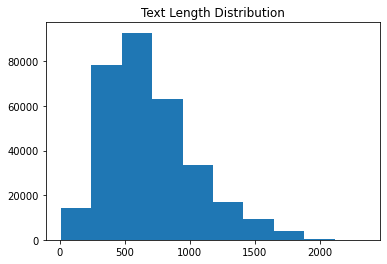

In [34]:
%matplotlib inline
plt.hist(text_len)
plt.title('Text Length Distribution')
plt.show()

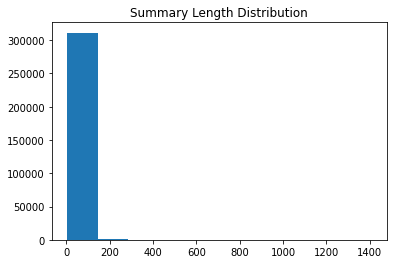

In [36]:
plt.hist(summary_len)
plt.title('Summary Length Distribution')
plt.show()

In [5]:
class cnn_dailymail(Dataset):
    def __init__(self, tokenizer, type_path, input_length, output_length):         
        raw_dataset =  load_dataset('cnn_dailymail', '2.0.0')
        self.dataset = raw_dataset[type_path]
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length

      
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        input_ = self.clean_text(example_batch['article'])
        target_ = self.clean_text(example_batch['highlights'])
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

In [6]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

In [8]:
train_dataset = cnn_dailymail(tokenizer, 'train', 512, 250)
val_dataset = cnn_dailymail(tokenizer, 'validation', 512, 250)
test_dataset = cnn_dailymail(tokenizer, 'test', 512, 250)

Reusing dataset cnn_dailymail (/home/axelallen/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)
Reusing dataset cnn_dailymail (/home/axelallen/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)
Reusing dataset cnn_dailymail (/home/axelallen/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


In [35]:
len(train_dataset.dataset['article'][0].split(" "))

1544

In [11]:
example = train_dataset.__getitem__(0)

In [12]:
example['source_ids'].shape

torch.Size([512])

In [44]:
example['target_ids'].shape

torch.Size([250])

In [38]:
example

{'source_ids': tensor([   94,    31,     7,  ..., 19602,    24,     1]),
 'source_mask': tensor([1, 1, 1,  ..., 1, 1, 1]),
 'target_ids': tensor([16706,  2314,    10,  4534,     3, 23626,    12,     8,   420,    13,
             8,  2195,     6,   744,    31,    17,   214,   149,    12,   129,
           323,   667,   115,   265,     9,  1299,     7,     3,     9,  2068,
            12,     8,  7701,    13,     8,  1384,    11,  7819,     3,     5,
           667,   115,   265,     9,    12,  2762, 28167,  5142,    30,  2716,
          1041,   581, 11380,     3,     5,   188,   603,    19,    12,  2082,
           823,     3, 18105,   130,   261,     6,    59,    57,  4068,     6,
           845,   412,     5,   567,     5,     3,     7, 18461,     3,     5,
             1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,  

## Configure Model

In [9]:
args_dict = dict(
    output_dir="./model_outputs/", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=1,
    #n_gpu=0,
    max_grad_norm=1.0,
    freeze_embeds=True,
    freeze_encoder=True,
    seed=42
)

args = argparse.Namespace(**args_dict)

In [10]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(args.seed)

In [11]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams.update(vars(hparams))  
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        self.rouge_metric = load_metric('rouge') 
        
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
        
    
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
            
    def freeze_embeds(self):
        """Freeze token embeddings and positional embeddings for bart, just token embeddings for t5."""
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))
    
    '''
    def is_logger(self):
        return self.trainer.proc_rank <= 0
    '''
    
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
        
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
    )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
#         rouge: Dict = self.calc_generative_metrics(preds, target)
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)

        self.rouge_metric.add_batch(predictions=preds, references=target)

        #rouge_results = self.rouge_metric.compute() 
        #rouge_dict = self.parse_score(rouge_results)
        #base_metrics.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        rouge_results = self.rouge_metric.compute() 
        rouge_dict = self.parse_score(rouge_results)
    
        tensorboard_logs.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "rouge1" : rouge_results['rouge1'],
                "rougeL" : rouge_results['rougeL'],
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
    
    def optimizer_step(self,
                     epoch=None,
                     batch_idx=None,
                     optimizer=None,
                     optimizer_idx=None,
                     optimizer_closure=None,
                     on_tpu=None,
                     using_native_amp=None,
                     using_lbfgs=None):

      optimizer.step(closure=optimizer_closure)
      optimizer.zero_grad()
      self.lr_scheduler.step()

    '''
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    '''
    

    def train_dataloader(self):   
        train_dataset =  cnn_dailymail(tokenizer=self.tokenizer, type_path="train", input_length=512, output_length=250)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=1)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * 1)) #max(1, self.hparams.n_gpu)
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        validation_dataset =  cnn_dailymail(tokenizer=self.tokenizer, type_path="validation", input_length=512, output_length=250)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=1)
    
    
    def test_dataloader(self):
        test_dataset =  cnn_dailymail(tokenizer=self.tokenizer, type_path="test", input_length=512, output_length=250)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=1)

#### Below Needs editing

In [12]:
class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

In [12]:
## Define Checkpoint function
'''
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir, monitor="val_loss", mode="min", save_top_k=3
)
'''
## If resuming from checkpoint, add an arg resume_from_checkpoint
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    max_epochs=args.num_train_epochs,
    gradient_clip_val=args.max_grad_norm
    #gpus=args.n_gpu,
    #checkpoint_callback=checkpoint_callback,
    #logger=wandb_logger,
    #callbacks=[LoggingCallback()],
)

In [13]:
model = T5FineTuner(args)
trainer = pl.Trainer(**train_params, fast_dev_run=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).


In [ ]:
#%pdb on
trainer.fit(model)


  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
113 M     Trainable params
109 M     Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


In [20]:
!tensorboard --logdir ./lightning_logs

2021-05-18 16:03:37.666994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)
